In [3]:
# import
import pickle
import numpy as np
#import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import umap

## Visualize Prototypes

In [1]:
client = 8
round = 49
data = "cifar10"

In [2]:
# with open('protos/proto_round_'+str(round)+'.pkl', 'rb') as file:
#     data_np = pickle.load(file).cpu()

# with open('protos/labels_round_'+str(round)+'.pkl', 'rb') as file:
#     labels_np = pickle.load(file).cpu()
# noloss2protos
with open('protos/'+data+'_client_ufedp_'+str(client)+'_proto_round_'+str(round)+'.pkl', 'rb') as file:
    data_np = pickle.load(file).cpu()

with open('protos/'+data+'_client_ufedp_'+str(client)+'_labels_round_'+str(round)+'.pkl', 'rb') as file:
    labels_np = pickle.load(file).cpu()

# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_np)

# Get unique labels
unique_labels = np.unique(labels_np)

# Define a color map (adjust if you have more than 10 labels)
colors = plt.cm.tab10.colors  # Tab10 colormap has 10 distinct colors

# Create a mapping from labels to colors
label_color_dict = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

NameError: name 'pickle' is not defined

In [39]:
len(labels_np), data_np.shape

(1800, torch.Size([1800, 120]))

In [40]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_np)

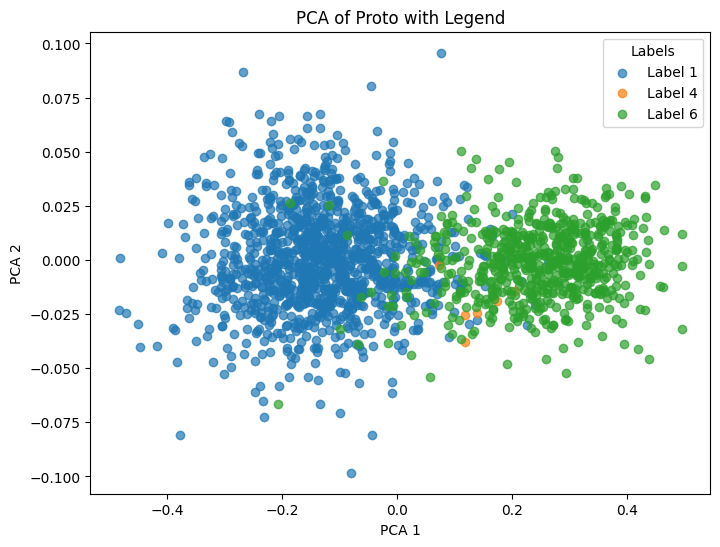

In [41]:
'''
Note:
  - plot the global prototypes inside the plot.
'''
# Plot the data
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = labels_np == label
    plt.scatter(
        data_pca[indices, 0],
        data_pca[indices, 1],
        color=label_color_dict[label],
        label=f'Label {label}',
        alpha=0.7
    )

#scatter = plt.scatter(proto_pca[unique_labels][:, 0], proto_pca[unique_labels][:, 1], color='red')
# Annotate each point with its key
#for i in unique_labels:
#    plt.annotate(str(i), (proto_pca[i, 0], proto_pca[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(title='Labels')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Proto with Legend')
plt.show()

# using UMAP

In [119]:
import numpy as np
import umap
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [120]:
digits = load_digits()
data = digits.data


In [121]:
data.shape

(1797, 64)

In [84]:
len(digits.target)

1797

/Users/joetelila/UWO/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



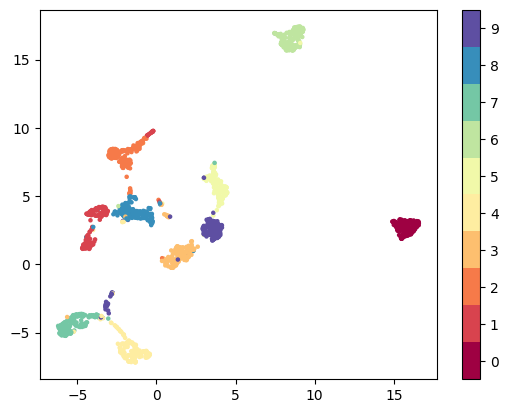

In [76]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Apply UMAP
reducer = umap.UMAP(random_state=12)
embedding = reducer.fit_transform(data)
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.show()

# Loading dataset from a file

In [1]:
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets import FederatedDataset
from flwr_datasets.preprocessor import Merger

# torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import torch

# utils
import pandas as pd
import numpy as np

# huggingface dataset
from datasets import Dataset
from datasets import concatenate_datasets
from types import SimpleNamespace
from utils.data_utils import convert_to_hf_dataset
from utils.train_utils import *
from utils.model import *
import copy

/Users/joetelila/UWO/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from datasets import load_dataset
# hf_dataset = load_dataset("ylecun/mnist", split="train")

In [3]:
args = SimpleNamespace(
    batchsize=32,
    clients=6,
    alpha=0.1,
    split=0.2,
    ufedproto=False,
    seed=42,
    isiid=False,
    device='mps',
    k=10,
    lr=0.001,
    momentum=0.95,
    epoch=5,
    data='cifar10',
    ld=2,
    clog=True,
    pfl=False
)

In [4]:
torch.manual_seed(99)
global_proto = {
    i: torch.rand(120) for i in range(args.k)
}

_client = 0

global_model = Cifar10Net().to(args.device)
clients = [global_model for _ in range(args.clients)]
_client_model = copy.deepcopy(clients[_client])

In [5]:
def convert_to_hf_dataset(train_data, test_data=None):
    data_dict = {
        "image": [],
        "label": []
    }
    
    for image, label in train_data:
        data_dict["image"].append(image)  # Convert to tensor
        data_dict["label"].append(label)
    
    if test_data is not None:
        for image, label in test_data:
            data_dict["image"].append(image)
            data_dict["label"].append(label)

    return data_dict

In [6]:
# prepare Dataset
if args.data == 'mnist':
    trainset = torchvision.datasets.MNIST(root='./datasets/mnist/', train=True, download=False)
    testset = torchvision.datasets.MNIST(root='./datasets/mnist/', train=False, download=False)
elif args.data == 'cifar10':
    trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/', train=True, download=False)
    testset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/', train=False, download=False)
else:
    raise ValueError("Invalid dataset")


if args.ufedproto:
    # combine everything together
    ds_trainset = Dataset.from_dict(convert_to_hf_dataset(trainset,testset))
else:
    ds_trainset = Dataset.from_dict(convert_to_hf_dataset(trainset))
    ds_testset = Dataset.from_dict(convert_to_hf_dataset(testset))

In [15]:
# create partitioner
partitioner = IidPartitioner(
                        num_partitions=args.clients,
                        #partition_by="label",
                    ) if args.isiid else DirichletPartitioner(
                        num_partitions=args.clients,
                        partition_by="label",
                        alpha=args.alpha,
                        seed=args.seed,
                        min_partition_size=500,
                        self_balancing=True,
                        #num_classes_per_partition = 4
                    )

In [16]:
def save_label_distribution(args, partitioner):
    fig, ax, df = plot_label_distributions(
        partitioner,
        label_name="label",
        plot_type="heatmap",
        size_unit="absolute",
        partition_id_axis="x",
        legend=True,
        verbose_labels=True,
        title="Per Partition Labels Distribution",
        plot_kwargs={"annot": True},
    )
    # Save the plot
    fig.savefig("plots/"+args.data+"_label_distribution.png")

/Users/joetelila/UWO/lib/python3.12/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


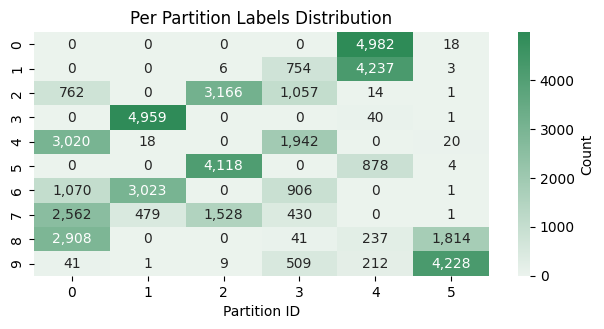

In [17]:
if args.ufedproto:
    # combine train and test datasets
    # partition the data to the amount of number of clients
    # create test and train set for each client from the partition.
    # prepare the data loader.

    # combine everything together
    ds_dataset = Dataset.from_dict(convert_to_hf_dataset(trainset,testset))
    partitioner.dataset = ds_dataset
    
    # save label distribution
    save_label_distribution(partitioner)

    # load specific client data
    client_data = partitioner.load_partition(partition_id=_client)

    # create train and test set for the client
    partition_train_test = client_data.train_test_split(test_size=args.split, seed=args.seed)
    client_train = partition_train_test["train"]
    client_test = partition_train_test["test"]

else:
    # partition the train set of the dataset
    # use that partition to create trainset 
    # and global test set for each client test set.
    ds_trainset = Dataset.from_dict(convert_to_hf_dataset(trainset))
    ds_testset = Dataset.from_dict(convert_to_hf_dataset(testset))

    # partition the data
    partitioner.dataset = ds_trainset

    # save label distribution
    save_label_distribution(partitioner)

    client_train = partitioner.load_partition(partition_id=_client)
    client_test = ds_testset    

In [9]:
client_train, client_test

(Dataset({
     features: ['image', 'label'],
     num_rows: 10363
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 10000
 }))

In [10]:

if args.data=='mnist':
       _transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
elif args.data=='cifar10':
       _transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
       raise ValueError("Invalid dataset")
def apply_transforms(batch):
       batch["image"] = [_transforms(img) for img in batch["image"]]
       return batch
client_train = client_train.with_transform(apply_transforms)
client_test = client_test.with_transform(apply_transforms)
trainloader = DataLoader(client_train, batch_size=args.batchsize)

In [11]:
_client_model_trained = train(args, _client_model, trainloader, global_proto)

Epoch 1: train loss 0.05352865532040596, accuracy 0.34903020360899356, loss1 1.3072443008422852, loss2 0.0
Epoch 2: train loss 0.03803660348057747, accuracy 0.5203126507768021, loss1 1.11465585231781, loss2 0.0
Epoch 3: train loss 0.033893030136823654, accuracy 0.5830358004438869, loss1 1.0164841413497925, loss2 0.0
Epoch 4: train loss 0.03109578602015972, accuracy 0.6205731930908038, loss1 0.8644524812698364, loss2 0.0
Epoch 5: train loss 0.029264941811561584, accuracy 0.6468204187976455, loss1 0.7591791749000549, loss2 0.0


# Hugging Face

In [10]:
from datasets import load_dataset
hf_dataset = load_dataset("ylecun/mnist", split="train")

In [7]:
type(hf_dataset)

datasets.arrow_dataset.Dataset

In [22]:
type(hf_dataset['image'])

list

In [8]:
_client = 0
partitioner = IidPartitioner(
                        num_partitions=6,
                        #partition_by="label",
                    )
partitioner.dataset = datass
client_train = partitioner.load_partition(partition_id=_client)

pytorch_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
def apply_transforms(batch):
       batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
       return batch
client_train = client_train.with_transform(apply_transforms)

trainloader = DataLoader(client_train, batch_size=args.batchsize)

In [11]:
_client_model_trained = train(args, _client_model, trainloader, global_proto)

Epoch 1: train loss 0.049954887479543686, accuracy 0.497, loss1 0.3247183859348297, loss2 0.0
Epoch 2: train loss 0.01211099699139595, accuracy 0.8815, loss1 0.12134433537721634, loss2 0.0
Epoch 3: train loss 0.007201749365776777, accuracy 0.9299, loss1 0.08728402853012085, loss2 0.0
Epoch 4: train loss 0.0054415022023022175, accuracy 0.9506, loss1 0.040437087416648865, loss2 0.0
Epoch 5: train loss 0.0042752656154334545, accuracy 0.96, loss1 0.024476805701851845, loss2 0.0


# EMNIST

In [1]:
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets import FederatedDataset
from flwr_datasets.preprocessor import Merger

# torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import torch

# utils
import pandas as pd
import numpy as np

# huggingface dataset
from datasets import Dataset
from datasets import concatenate_datasets
from types import SimpleNamespace
from utils.data_utils import convert_to_hf_dataset
from utils.train_utils import *
from utils.model import *
import copy

/Users/joetelila/UWO/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
trainset = torchvision.datasets.EMNIST(root="./datasets/mnist/emnist/",
                                   split="bymerge",
                                   train=True,
                                   download=True,  # Set to False since you already downloaded it 
                                   transform=transforms.ToTensor())

In [8]:
trainset.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

In [1]:
import torch

In [2]:
# Define the vector
L = torch.tensor([3.0, 4.0])

# Calculate the L2 norm (magnitude) of the vector
L_norm = torch.norm(L, p=2)

# Perform L2 normalization by dividing each component by the L2 norm
L_normalized = L / L_norm

print("Original Vector:", L)
print("L2 Norm of Vector:", L_norm)
print("Normalized Vector:", L_normalized)

Original Vector: tensor([3., 4.])
L2 Norm of Vector: tensor(5.)
Normalized Vector: tensor([0.6000, 0.8000])


In [3]:
import torch

# Example tensors
t1 = torch.rand(16, 120)  # Tensor of size [16, 120]
t2 = torch.rand(10, 120)  # Tensor of size [10, 120]

# Normalize t1 and t2 along the last dimension for cosine similarity (optional, only if cosine similarity is desired)
t1_normalized = t1 / t1.norm(dim=1, keepdim=True)
t2_normalized = t2 / t2.norm(dim=1, keepdim=True)

# Compute cosine similarity (or 1 - cosine similarity for distance)
cosine_sim = torch.mm(t1_normalized, t2_normalized.T)

# Find the closest match by taking the max index (for cosine similarity)
closest_t2_indices = cosine_sim.argmax(dim=1)

print("Closest t2 indices for each tensor in t1:", closest_t2_indices)

Closest t2 indices for each tensor in t1: tensor([3, 1, 8, 6, 6, 1, 1, 1, 1, 3, 5, 9, 8, 1, 1, 3])


In [7]:
t2

tensor([[0.0989, 0.7100, 0.5259,  ..., 0.1378, 0.8907, 0.7994],
        [0.3997, 0.7782, 0.8607,  ..., 0.0803, 0.2770, 0.1182],
        [0.9519, 0.4841, 0.2468,  ..., 0.0401, 0.5147, 0.1789],
        ...,
        [0.2097, 0.4184, 0.2753,  ..., 0.7169, 0.9801, 0.6086],
        [0.3418, 0.8835, 0.5209,  ..., 0.4482, 0.0929, 0.4315],
        [0.6262, 0.5100, 0.9045,  ..., 0.3120, 0.9757, 0.4597]])

In [13]:
epochs = 50
for i in range(50):
    # Create a scaling factor that starts small, peaks in the middle, and reduces toward the end
    scaling_factor = 0.2 * 0.5 * (1 - torch.cos(torch.tensor(i * 3.14159 / (epochs - 1))))

    print(scaling_factor)

tensor(0.)
tensor(0.0002)
tensor(0.0008)
tensor(0.0018)
tensor(0.0033)
tensor(0.0051)
tensor(0.0073)
tensor(0.0099)
tensor(0.0129)
tensor(0.0162)
tensor(0.0199)
tensor(0.0239)
tensor(0.0282)
tensor(0.0328)
tensor(0.0377)
tensor(0.0428)
tensor(0.0482)
tensor(0.0537)
tensor(0.0595)
tensor(0.0655)
tensor(0.0715)
tensor(0.0777)
tensor(0.0840)
tensor(0.0904)
tensor(0.0968)
tensor(0.1032)
tensor(0.1096)
tensor(0.1160)
tensor(0.1223)
tensor(0.1285)
tensor(0.1345)
tensor(0.1405)
tensor(0.1463)
tensor(0.1518)
tensor(0.1572)
tensor(0.1623)
tensor(0.1672)
tensor(0.1718)
tensor(0.1761)
tensor(0.1801)
tensor(0.1838)
tensor(0.1871)
tensor(0.1901)
tensor(0.1927)
tensor(0.1949)
tensor(0.1967)
tensor(0.1982)
tensor(0.1992)
tensor(0.1998)
tensor(0.2000)


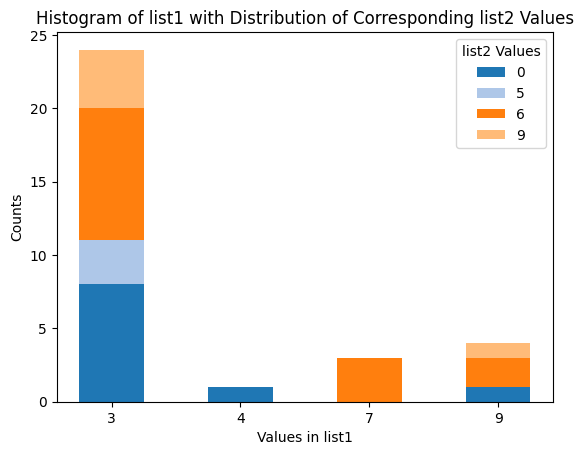

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Your lists
list1 = [3, 3, 4, 3, 3, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 3, 3, 9, 9, 9, 3, 9, 3, 3, 3, 3, 3, 3]
list2 = [6, 0, 0, 0, 0, 6, 9, 6, 6, 0, 5, 6, 6, 5, 9, 6, 6, 6, 5, 9, 6, 6, 6, 9, 6, 0, 0, 0, 0, 0, 9, 6]

# Step 1: Find unique values in list1 and list2
unique_list1_values = sorted(set(list1))
unique_list2_values = sorted(set(list2))

# Step 2: Initialize a data structure to hold counts
list2_value_to_index = {v: i for i, v in enumerate(unique_list2_values)}
data = np.zeros((len(unique_list2_values), len(unique_list1_values)))

# Step 3: Populate the data array with counts
for idx1, val1 in enumerate(unique_list1_values):
    indices = [i for i, x in enumerate(list1) if x == val1]
    corresponding_list2 = [list2[i] for i in indices]
    counts = {}
    for val2 in corresponding_list2:
        counts[val2] = counts.get(val2, 0) + 1
    for val2, count in counts.items():
        idx2 = list2_value_to_index[val2]
        data[idx2, idx1] = count

# Step 4: Plot the stacked bar chart
labels = [str(val) for val in unique_list1_values]
x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots()

bottom = np.zeros(len(unique_list1_values))
colors = plt.cm.tab20.colors  # You can choose a different colormap if you like

for i in range(len(unique_list2_values)):
    ax.bar(labels, data[i], width, bottom=bottom, label=str(unique_list2_values[i]), color=colors[i])
    bottom += data[i]

# Step 5: Add labels and legend
ax.set_xlabel('Values in list1')
ax.set_ylabel('Counts')
ax.set_title('Histogram of list1 with Distribution of Corresponding list2 Values')
ax.legend(title='list2 Values')

plt.show()


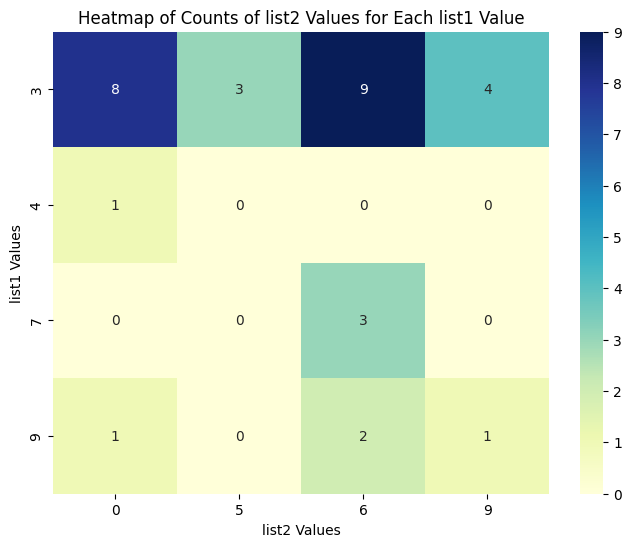

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
df = pd.DataFrame({'list1': list1, 'list2': list2})

# Create a pivot table
pivot_table = df.pivot_table(index='list1', columns='list2', aggfunc=len, fill_value=0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Counts of list2 Values for Each list1 Value')
plt.xlabel('list2 Values')
plt.ylabel('list1 Values')
plt.show()


## U-fedproto visualization

In [1]:
import pickle

In [8]:
# with open('protos/proto_round_'+str(round)+'.pkl', 'rb') as file:
#     data_np = pickle.load(file).cpu()

# with open('protos/labels_round_'+str(round)+'.pkl', 'rb') as file:
#     labels_np = pickle.load(file).cpu()
# noloss2protos
with open('protos-ufedp/client_16_ufedp_k_6_hidden_64_proto_round_18.pkl', 'rb') as file:
    data_np = pickle.load(file).cpu().detach()

with open('protos-ufedp/client_16_ufedp_k_6_hidden_64_labels_round_18.pkl', 'rb') as file:
    labels_np = pickle.load(file).cpu()

In [9]:
data_np.shape, labels_np.shape

(torch.Size([7638, 64]), torch.Size([7638]))

In [10]:

# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_np)

# Get unique labels
unique_labels = np.unique(labels_np)

# Define a color map (adjust if you have more than 10 labels)
colors = plt.cm.tab10.colors  # Tab10 colormap has 10 distinct colors

# Create a mapping from labels to colors
label_color_dict = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

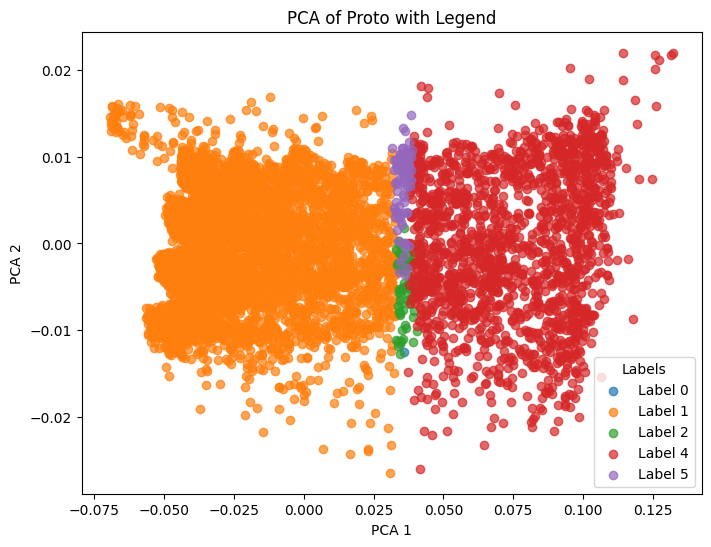

In [11]:
'''
Note:
  - plot the global prototypes inside the plot.
'''
# Plot the data
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = labels_np == label
    plt.scatter(
        data_pca[indices, 0],
        data_pca[indices, 1],
        color=label_color_dict[label],
        label=f'Label {label}',
        alpha=0.7
    )

#scatter = plt.scatter(proto_pca[unique_labels][:, 0], proto_pca[unique_labels][:, 1], color='red')
# Annotate each point with its key
#for i in unique_labels:
#    plt.annotate(str(i), (proto_pca[i, 0], proto_pca[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(title='Labels')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Proto with Legend')
plt.show()

In [15]:
import torch.nn as nn
import torch

In [21]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

In [22]:
out.shape

torch.Size([10, 32, 512])